data/testdata/testfor_radius/data1.mat
data/testdata/testfor_radius/data5.mat


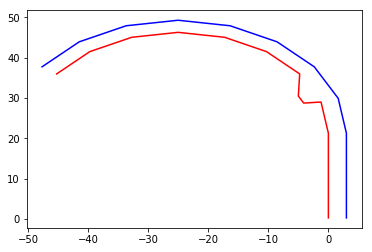

In [10]:
from math import *
import sympy
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import copy
import os

#############################################################################################################################
## this track recognition function is operated by some evalation: distance, fitting line and so on

# get the data from .mat
def getdata(strt):
    print(strt)
    load_data = sio.loadmat(strt)
    left1 = load_data['left'] 
    right1 = load_data['right']
    position = load_data['position']
    a = position[0][0]
    b = position[0][1]
    position = [a,b]
    left = []
    right = []
    for i in range(len(left1)):
        left.append([])
        for j in range(len(left1[i])):
            left[i].append(left1[i][j])
    for i in range(len(right1)):
        right.append([])
        for j in range(len(right1[i])):
            right[i].append(right1[i][j])
    
    return left,right,position

# get the nummber from the Dataname

def numerical(str):
    num = ''
    get = False
    for i in range(len(str)):
        if str[i].isdigit():
            num = num + str[i]
            get = True
    if not get:
        numm = 999999
    else:
        numm = int(num)
    return numm


# find out wether this side of track has a big error
# the case that car recognize the cones from other track will only happen 
# when there is a corn, which means the distance between wrong cones and
# the average will be very large


def distance_between(new,old):
    return sqrt((new[0]-old[0])**2 + (new[1]-old[1])**2)

# sort from the distance between the cones and the cars, or select the first cones with the line
# plan: plane[0]: distance between the origin and the line
#       plane[1]: winkel 
def sort_dis_find(position,measurements,method = 1,plane = [0,0]): # sort the cones by distance from the first cones
    # method == 1: sort with nearst line which made by both side of cones
    # method == 0: direct sort by distance
    ran = []
    ret = []
    nummber = 2 # the nummber of the cones I pick
    # first sort the cones with the distance from the car
    for j in range(len(measurements)):
        ran.append([])
        for i in range(len(measurements[j])):
            dx = measurements[j][i][0] - position[0]
            dy = measurements[j][i][1] - position[1]
            ran[j].append([])
            ran[j][i].append(sqrt(dx**2 + dy**2))
            for n in range(len(measurements[j][i])):
                ran[j][i].append(measurements[j][i][n])  
        ran[j].sort()
    if method: # method 1# find the first three cones of both side, selcet the cones, which minimize the distance 
        # between the cars and the lines
        left_min = []
        right_min = []
        for m in range(nummber):
            left_min.append([])
            right_min.append([])
            left_min[m].append(ran[0][m])
            right_min[m].append(ran[1][m])
        lines = []
        mc = 0
        for ml in range(nummber):
            for mr in range(nummber):
                lines.append([])
                dx = left_min[ml][0][1] - right_min[mr][0][1]
                dy = left_min[ml][0][2] - right_min[mr][0][2]
                winkel = atan2(dy,dx) + pi/2
                dphi = abs((left_min[ml][0][1]-position[0])*cos(winkel) + (left_min[ml][0][2] - position[1])*sin(winkel))
                lines[mc].append(dphi)
                lines[mc].append(winkel)
                lines[mc].append(ml)
                lines[mc].append(mr)
                mc = mc + 1
        lines.sort()
        plane[0] = lines[0][0]
        plane[1] = lines[0][1]
        
        # resort the cones with the selected starting cones
        for j in range(2):
            ren = ran
            for i in range(len(ren[j])):
                if i == lines[0][2+j]:
                    ren[j][i][0] = 0
            ren[j].sort()
            
        for n in range(2):
            ret.append([])
            for i in range(len(ren[n])):
                del ren[n][i][0]
                ret[n].append(ren[n][i])
    else:
        for n in range(2):
            ret.append([])
            for i in range(len(ran[n])):
                del ran[n][i][0]
                ret[n].append(ran[n][i])
                
        return ret[0],ret[1]

# sort the cones with defined beginning
def sort_dis_def(measurements,toler):
    
    sorte = []
    ret = []
# get the distance between each cone and the beginning cone
    for f in range(len(measurements)):
        sorte.append([])
        for i in range(len(measurements[f])):
            a = distance_between(measurements[f][i],measurements[f][0])
            sorte[f].append([a,measurements[f][i]])        
# sort the cones
    for i in range(len(sorte)):
        a = sorte[i]
        a.sort()
        sorte[i] = a
        
# creat the return
    for f in range(len(sorte)):
        nobroken = True
        ret.append([])
        if len(sorte[f]) == 1:
            continue
        for i in range(len(sorte[f])-1):
            if sqrt((sorte[f][i][1][0]-sorte[f][i+1][1][0])**2 + (sorte[f][i][1][1]-sorte[f][i+1][1][1])**2) > toler:
                break
                nobroken = False
            ret[f].append(sorte[f][i][1])
        if nobroken:
            ret[f].append(sorte[f][i+1][1])
    
    return ret

# seperate the cones from the i-th
def seperate(i,cones):
    delect = []
    while i < len(cones):
        delect.append(cones[i])
        del cones[i]
        
    return cones,delect

# find out if there is a change for the position and delect the cones that are already detected in the past
def findchange(origin,new):
    change = []
    renew = []
    for i in range(len(new)):
        notsame = True
        for j in range(len(origin)):
            if new[i][2] == origin[j][2]:
                notsame = False
                if new[i][0] != origin[j][0] or new[i][1] != origin[j][1]:
                    origin[j][0] = new[i][0]
                    origin[j][1] = new[i][1]
                    change.append(j)
                break
        if notsame:
            renew.append(new[i])
                
    return origin,renew,change

# find which part of the track that the car/cone is
def find_position(track,cone,index):
    
    distance = None
    i = 0
    for i in range(len(track)-index-1):
        
        dx = track[index+i+1][0] - track[index+i][0]
        dy = track[index+i+1][1] - track[index+i][1]
    
        Rx = cone[0] - track[index+i][0]
        Ry = cone[1] - track[index+i][1]
        dte =(Rx * dx + Ry * dy)/(dx**2 + dy**2)
        
        if dte <= 1 and dte > 0:
            distance = (Ry*dx-Rx*dy)/sqrt(dx**2+dy**2)
            break   
            
    return index+i, abs(distance)

# give the minimum track width
def mintrack_width(track,cone_beginn,cone_end):
    distance = []
    a,b = find_position(track,cone_beginn,0)
    distance.append(b)
    c,d = find_position(track,cone_end,a)
    distance.append(d)
    if a < c:
        e,f = find_position([cone_beginn,cone_end],track[c],0)
        distance.append(f)
        
    return(min(distance))

# find the radius of three cones
def findradius(cone1,cone2,cone3):
    
    if atan2(cone2[1]-cone1[1],cone2[0]-cone1[0]) == atan2(cone3[1]-cone2[1],cone3[0]-cone2[0]):
        radius = 999
    else:
        a,b = sympy.symbols('a b')
        answer = sympy.solve([sympy.Eq(2*a*(cone1[0]-cone2[0])+2*b*(cone1[1]-cone2[1])\
                                       +cone2[0]**2+cone2[1]**2-cone1[0]**2-cone1[1]**2),
                              sympy.Eq(2*a*(cone2[0]-cone3[0])+2*b*(cone2[1]-cone3[1])\
                                       +cone3[0]**2+cone3[1]**2-cone2[0]**2-cone2[1]**2)],[a,b])

        radius = sqrt((answer[a]-cone1[0])**2+(answer[b]-cone1[1])**2)
        
    return radius

# check the cretierien for the minimum track width and turning radius
# input of this function is the rolerate and two track, each one should include the 
# new adding cones range and the last two cones of the old cones
def check(measurements,cone_pos_rel,left,right,width,radius):
    # check the turning radius
    che_left = []
    che_right = []
    if left:
        checklist = [measurements[0][-2],measurements[0][-1]]
        i = 0
        while i < len(left):
            if findradius(checklist[0],checklist[1],left[i]) >= radius[0]:
                che_left.append(left[i])
                checklist = [checklist[1],left[i]] # update the checklist
                i = i + 1
                
            elif radius[1] >= 1 and len(left)-i >= 2 and findradius(checklist[0],checklist[1],left[i+1]) >= radius[0]:
                # it is an error and won't be taken from the old cones to check the new cone after added
                che_left.append(left[i]) 
                che_left.append(left[i+1])
                checklist = [checklist[1],left[i+1]]
                i = i+2
            elif radius[1] == 2 and len(left)-i >= 3 and findradius(checklist[0],checklist[1],left[i+2]) >= radius[0]:
                # they are error and won't be taken from the old cones to check the new cone after added
                che_left.append(left[i]) 
                che_left.append(left[i+1])
                che_left.append(left[i+2])
                checklist = [checklist[1],left[i+2]]
                i = i+3
            else:
                break
    
    if right:
        checklist = [measurements[1][-2],measurements[1][-1]]
        i = 0
        while i < len(right):
            if findradius(checklist[0],checklist[1],right[i]) >= radius[0]:
                che_right.append(right[i])
                checklist = [checklist[1],right[i]] # update the checklist
                i = i + 1
            elif radius[1] >= 1 and len(right)-i >= 2 and findradius(checklist[0],checklist[1],right[i+1]) >= radius[0]:
                # it is an error and won't be taken from the old cones to check the new cone after added
                che_right.append(right[i]) 
                che_right.append(right[i+1])
                checklist = [checklist[1],right[i+1]]
                i = i+2
            elif radius[1] == 2 and len(right)-i >= 3 and findradius(checklist[0],checklist[1],right[i+2]) >= radius[0]:
                # it is an error and won't be taken from the old cones to check the new cone after added
                che_right.append(right[i]) 
                che_right.append(right[i+1])
                che_right.append(right[i+2])
                checklist = [checklist[1],right[i+2]]
                i = i+3
            else: 
                break
    
    measurements[0] = measurements[0] + che_left
    measurements[1] = measurements[1] + che_right
    
    return cone_pos_rel,measurements

# show the track
def showtrack(measurements,str):
    c = ['r','b']
    for j in range(len(measurements)):
        a = []
        b = []
        for i in range(len(measurements[j])):
            a.append(measurements[j][i][0])
            b.append(measurements[j][i][1])
        plt.plot(a, b, c = c[j%2])
    name = str
    name = 'data/figout/' + name.replace("mat","jpg")
    plt.savefig(name)  
    plt.show()

def track_rec(data,measurements,position,notfind,cone_pos_rel,toler,width,radius):
    [left,right,a] = data[0],data[1],data[2]
    position.append(a)
    notfirst = True
    
    if data[3] == 'sta':
        measurements = sta(measurements,[left,right],toler)

    else:
        if len(measurements) == 0:
            measurements.append(left)
            measurements.append(right)
            notfirst = False
        
        if notfind:
            if len(measurements[0]) >= 2 and len(measurements[1]) >= 2:
                measurements = sort_dis_find(position[0],measurements,0)
                notfind = False
            elif notfirst: 
                [measurements[0],left,xx] = findchange(measurements[0],left)
                [measurements[1],right,xx] = findchange(measurements[1],right)
                measurements[0] = measurements[0] + left
                measurements[1] = measurements[1] + right
    
        else :
            measurements = list(measurements)
            [measurements[0],left,changeleft] = findchange(measurements[0],left)
            [measurements[1],right,changeright] = findchange(measurements[1],right)
        
    # give the previous cones to the new detected cones from the first changed position
            if len(changeleft) == 0:
                left1 = measurements[0][len(measurements[0])-1]
            else :
                [measurements[0],left1] = seperate(changeleft[0],measurements[0])
            if len(changeright) == 0:
                right1 = measurements[1][len(measurements[1])-1]
            else :
                [measurements[1],right1] = seperate(changeright[0],measurements[1])
        
            left = [left1] + left
            right = [right1] + right
            [left,right] = sort_dis_def([left,right], toler)
        
            xx,left = seperate(1,left)
            xx,right = seperate(1,right)
        
            # measurements[0] = measurements[0] + left
            # measurements[1] = measurements[1] + right
        
            # only add the cones which fullfill the condition
            cone_pos_rel,measurements = check(measurements,cone_pos_rel,left,right,width,radius)
        
    return measurements,position,notfind,cone_pos_rel

######### for the second round
# each input consist of two matrix: left and right, which includ the x,y,id
def sta(oldcones,newcones,toler):
    ret = oldcones
    check = newcones
    # add new cones or update the position
    for i in range(len(newcones)):
        add = []
        for j in range(len(newcones[i])):
            have = False
            for n in range(len(ret[i])):
                if newcones[i][j][2] == ret[i][n][2] and distance_between(newcones[i][j],ret[i][n]) > 0:
                    change = True
                    if n > 0 and distance_between(newcones[i][j],ret[i][n-1]) > toler:
                        change = False
                    if n < (len(ret[i])-1) and distance_between(newcones[i][j],ret[i][n+1]) > toler:
                        change = False
                    if change:
                        ret[i][n] = newcones[i][j]
                if newcones[i][j][2] == ret[i][n][2]:
                    have = True
                    break
            if have: 
                continue
            else:
                add.append(j)
        nomore = True
        while nomore:
            nomore = False
            for a in add:
                oldlength = len(ret[i])
                ret[i] = addnew(ret[i],newcones[i][a],toler)
                if len(ret[i]) > oldlength:
                    nomore = True
                    add.remove(a)
            
    # delect the cones that not in newcones
    for i in range(len(ret)):
        delect = []
        for j in range(len(ret[i])):
            have = False
            for n in range(len(check[i])):
                if ret[i][j][2] == check[i][n][2]:
                    have = True
                    break
            if have: 
                continue
            else:
                kick = True
                if j > 0 and j < (len(ret[i])-1) and distance_between(ret[i][j-1],ret[i][j+1]) > toler:
                    kick = False
                if kick:
                    delect.append(j)
        if delect:
            for d in range(len(delect)):
                del ret[i][delect[d]-d]
                
    return ret

# the function that can add new cones into the old one and rerange it

def addnew(old,cone,toler):
    ret = copy.deepcopy(old)
    distance = []
    # find the nearst cone
    for i in range(len(old)):
        distance.append([distance_between(cone,old[i]), i])
        
    distance.sort()
    index = distance[0][1]
    
    if index == 0 and distance_between(cone,ret[1]) < toler:
        rerange = [ret[0],ret[1],cone]
        rerange = sort_dis_def([rerange],toler)[0]
        if len(rerange) == 3:
            ret.append([])
            for j in range(len(ret)-3):
                ret[len(ret)-j-1] = ret[len(ret)-j-2]
            for n in range(len(rerange)):
                ret[n] = rerange[n]
        #print(ret,1)
            
    elif index == len(old)-1 and distance_between(cone,ret[index-1]) < toler:
        rerange = [ret[index-1],ret[index],cone]
        rerange = sort_dis_def([rerange],toler)[0]
        if len(rerange) == 3:
            ret.append([])
            for n in range(3):
                ret[index-1+n] = rerange[n]
        #print(ret,2)
            
    elif  distance_between(cone,ret[index-1]) < toler and distance_between(cone,ret[index+1]) < toler:
        rerange = [ret[index-1],ret[index],ret[index+1],cone]
        rerange = sort_dis_def([rerange],toler)[0]
        #print(rerange)
        if len(rerange) == 4:
            ret.append([])
            for j in range(len(ret)-index-3):
                ret[index+j+3] = ret[index+j+2]
            for n in range(len(rerange)):
                ret[index-1+n] = rerange[n]
        #print(ret,3)
    return ret

#############################################################################################################################

# get data

def publish():
    files = os.listdir('data/testdata/output')
    files = sorted(files,key=lambda s: numerical(s)) # read the data in the order of name
    measurements = []
    position = []
    readlist = []
    notfind = True
    cone_pos_rel = []
    toler = 10
    width = [4,1] # minimum track width and tolerant number of cones(can only be 1 or 2)
    radius = [25,1] # minimum turning radius and tolerant number of cones (can only be 1 or 2)
    for file in files:
        if '.mat' in file and file not in readlist:
            data = getdata('data/testdata/output/'+file)
            data = list(data)
            readlist.append(file)
            if 'sta' in file:
                data.append('sta')
            else: 
                data.append('dyn')
            measurements,position,notfind,cone_pos_rel = track_rec(data,measurements,position,notfind,cone_pos_rel,toler,width,radius)
            showtrack(measurements,file)

#publish()

def test_minwidth():
    files = os.listdir('data/testdata/testfor_pathwidth')
    files = sorted(files,key=lambda s: numerical(s)) # read the data in the order of name
    readlist = []
    for file in files:
        if '.mat' in file and file not in readlist:
            data = getdata('data/testdata/testfor_pathwidth/'+file)
            data = list(data)
            readlist.append(file)
            [left,right,a] = data[0],data[1],data[2]
            print(mintrack_width(left,right[0],right[1]))
            
#test_minwidth()

def test_radius():
    path = 'data/testdata/testfor_radius/'
    file1 = 'data1.mat'
    file2 = 'data5.mat'
    measurements = []
    position = []
    readlist = []
    notfind = True
    cone_pos_rel = []
    toler = 15
    width = [4,1] # minimum track width and tolerant number of cones(can only be 1 or 2)
    radius = [24,2] # minimum turning radius and tolerant number of cones (can only be 0, 1 or 2)
    
    data = getdata(path+file1)
    data = list(data)
    data.append('dyn')
    measurements,position,notfind,cone_pos_rel = track_rec(data,measurements,position,notfind,cone_pos_rel,toler,width,radius)
    # showtrack(measurements,'radius/'+file1)
    
    data = getdata(path+file2)
    data = list(data)
    data.append('dyn')
    measurements,position,notfind,cone_pos_rel = track_rec(data,measurements,position,notfind,cone_pos_rel,toler,width,radius)
    showtrack(measurements,'radius/'+file2)
    

test_radius()

In [4]:
import sympy
from math import *

def findradius(cone1,cone2,cone3):
    
    if atan2(cone2[1]-cone1[1],cone2[0]-cone1[0]) == atan2(cone3[1]-cone2[1],cone3[0]-cone2[0]):
        radius = 999
    else:
        a,b = sympy.symbols('a b')
        answer = sympy.solve([sympy.Eq(2*a*(cone1[0]-cone2[0])+2*b*(cone1[1]-cone2[1])\
                                       +cone2[0]**2+cone2[1]**2-cone1[0]**2-cone1[1]**2),
                              sympy.Eq(2*a*(cone2[0]-cone3[0])+2*b*(cone2[1]-cone3[1])\
                                       +cone3[0]**2+cone3[1]**2-cone2[0]**2-cone2[1]**2)],[a,b])
        radius = sqrt((answer[a]-cone1[0])**2+(answer[b]-cone1[1])**2)
        print(answer)
    return radius

print(findradius([0.0, 0.0, 7.0],[0.0, 2.0, 8.0],[2.0, 2.0, 9.0]))

{a: 1.00000000000000, b: 1.00000000000000}
1.4142135623730951
